In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = Path('../../Outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Set random seed for reproducibility
np.random.seed(42)

In [18]:
# Load training data
X_train = pd.read_csv('../../Data/X_train.csv')
y_train = pd.read_csv('../../Data/y_train.csv')

print("Training Data Shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print("\nFirst few rows of X_train:")
print(X_train.head())

Training Data Shape:
X_train: (400, 9)
y_train: (400, 1)

First few rows of X_train:
  User_ID  Age  Gender  Daily_Screen_Time(hrs)  Sleep_Quality(1-10)  \
0    U297   23  Female                     5.0                  5.0   
1    U221   23   Other                     5.2                  7.0   
2    U001   44    Male                     3.1                  7.0   
3    U256   33  Female                     5.9                  4.0   
4    U336   27    Male                     3.8                  8.0   

   Stress_Level(1-10)  Days_Without_Social_Media  Exercise_Frequency(week)  \
0                 7.0                        2.0                       4.0   
1                 6.0                        5.0                       1.0   
2                 6.0                        2.0                       5.0   
3                 7.0                        0.0                       3.0   
4                 6.0                        6.0                       4.0   

  Social_Media_Plat

In [19]:
# Check for missing values
print("Missing values in X_train:")
print(X_train.isnull().sum())
print("\nData types:")
print(X_train.dtypes)

Missing values in X_train:
User_ID                      0
Age                          0
Gender                       0
Daily_Screen_Time(hrs)       0
Sleep_Quality(1-10)          0
Stress_Level(1-10)           0
Days_Without_Social_Media    0
Exercise_Frequency(week)     0
Social_Media_Platform        0
dtype: int64

Data types:
User_ID                       object
Age                            int64
Gender                        object
Daily_Screen_Time(hrs)       float64
Sleep_Quality(1-10)          float64
Stress_Level(1-10)           float64
Days_Without_Social_Media    float64
Exercise_Frequency(week)     float64
Social_Media_Platform         object
dtype: object


In [20]:
# Encode categorical variables
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns: {categorical_cols}")

X_train_processed = X_train.copy()

# Label encode categorical variables (excluding User_ID)
label_encoders = {}
for col in categorical_cols:
    if col != 'User_ID':
        le = LabelEncoder()
        X_train_processed[col] = le.fit_transform(X_train_processed[col])
        label_encoders[col] = le

# Drop User_ID
if 'User_ID' in X_train_processed.columns:
    X_train_processed = X_train_processed.drop('User_ID', axis=1)

print("\nProcessed features:")
print(X_train_processed.head())

Categorical columns: ['User_ID', 'Gender', 'Social_Media_Platform']

Processed features:
   Age  Gender  Daily_Screen_Time(hrs)  Sleep_Quality(1-10)  \
0   23       0                     5.0                  5.0   
1   23       2                     5.2                  7.0   
2   44       1                     3.1                  7.0   
3   33       0                     5.9                  4.0   
4   27       1                     3.8                  8.0   

   Stress_Level(1-10)  Days_Without_Social_Media  Exercise_Frequency(week)  \
0                 7.0                        2.0                       4.0   
1                 6.0                        5.0                       1.0   
2                 6.0                        2.0                       5.0   
3                 7.0                        0.0                       3.0   
4                 6.0                        6.0                       4.0   

   Social_Media_Platform  
0                      1  
1        

In [21]:
# Prepare target variable
y_train_processed = y_train.values.ravel()

print(f"Total training samples: {X_train_processed.shape[0]}")
print(f"Number of features: {X_train_processed.shape[1]}")

Total training samples: 400
Number of features: 8


In [22]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_processed)
print(f"Scaled data shape: {X_train_scaled.shape}")

Scaled data shape: (400, 8)


In [23]:
# Define hyperparameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Initialize ElasticNet
elasticnet = ElasticNet(random_state=42, max_iter=10000)

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    elasticnet,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Train the model
grid_search.fit(X_train_scaled, y_train_processed)
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best l1_ratio: {grid_search.best_params_['l1_ratio']}")
print(f"Best CV MSE: {-grid_search.best_score_:.4f}")

Fitting 5 folds for each of 35 candidates, totalling 175 fits


Best alpha: 0.01
Best l1_ratio: 0.9
Best CV MSE: 0.8804


In [24]:
# Get best model and generate cross-validation predictions
best_model = grid_search.best_estimator_

# Get cross-validation predictions for the entire training set
y_pred_cv = cross_val_predict(best_model, X_train_scaled, y_train_processed, cv=5)

# Calculate cross-validation metrics
mse = mean_squared_error(y_train_processed, y_pred_cv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train_processed, y_pred_cv)
r2 = r2_score(y_train_processed, y_pred_cv)

print("Cross-Validation Performance (5-fold):")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

Cross-Validation Performance (5-fold):
MSE:  0.8804
RMSE: 0.9383
MAE:  0.7584
R²:   0.6300


Feature Coefficients (sorted by absolute value):
                     Feature  Coefficient
4         Stress_Level(1-10)    -0.723802
3        Sleep_Quality(1-10)     0.452537
2     Daily_Screen_Time(hrs)    -0.208779
5  Days_Without_Social_Media     0.079412
0                        Age     0.073051
6   Exercise_Frequency(week)     0.030319
7      Social_Media_Platform     0.024357
1                     Gender     0.000000


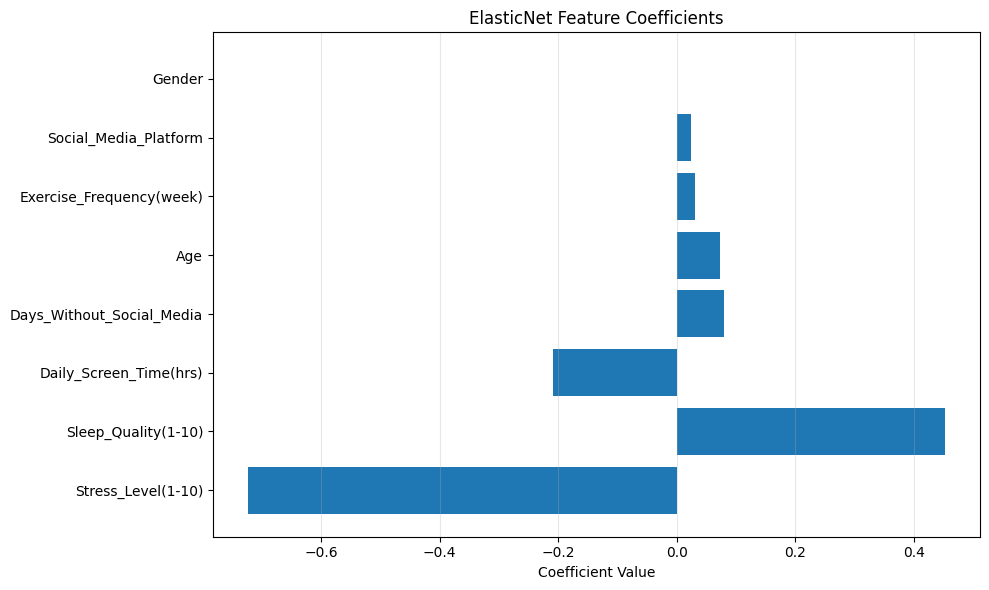


Features with non-zero coefficients: 7/8


In [25]:
# Analyze feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Coefficient': best_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature Coefficients (sorted by absolute value):")
print(feature_importance)

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('ElasticNet Feature Coefficients')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "elasticnet_feature_coefficients.png", dpi=300, bbox_inches='tight')
plt.show()

# Count non-zero coefficients
non_zero = np.sum(best_model.coef_ != 0)
print(f"\nFeatures with non-zero coefficients: {non_zero}/{len(feature_importance)}")

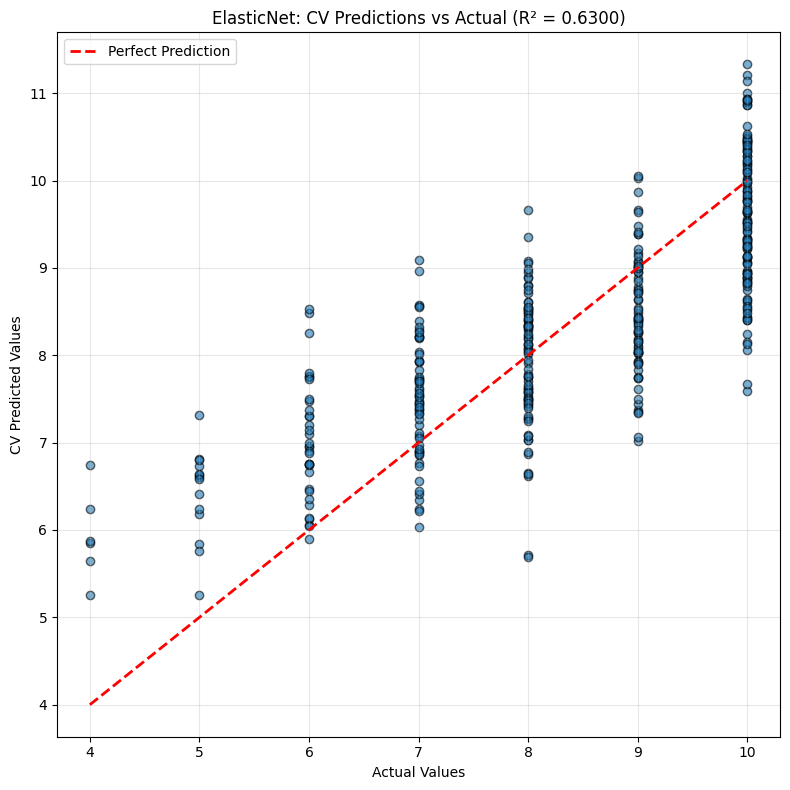

In [26]:
# Plot cross-validation predictions vs actual
plt.figure(figsize=(8, 8))
plt.scatter(y_train_processed, y_pred_cv, alpha=0.6, edgecolors='k')
plt.plot([y_train_processed.min(), y_train_processed.max()],
         [y_train_processed.min(), y_train_processed.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('CV Predicted Values')
plt.title(f'ElasticNet: CV Predictions vs Actual (R² = {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "elasticnet_cv_predictions_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# The best model has already been trained on the full training set via GridSearchCV
# Re-fit the final model to ensure it's trained on all data
best_model.fit(X_train_scaled, y_train_processed)

print(f"\nOptimal Hyperparameters:")
print(f"  - Alpha: {grid_search.best_params_['alpha']}")
print(f"  - L1 Ratio: {grid_search.best_params_['l1_ratio']}")
print(f"\nCross-Validation Performance:")
print(f"  - MSE: {mse:.4f}")
print(f"  - RMSE: {rmse:.4f}")
print(f"  - R²: {r2:.4f}")


Optimal Hyperparameters:
  - Alpha: 0.01
  - L1 Ratio: 0.9

Cross-Validation Performance:
  - MSE: 0.8804
  - RMSE: 0.9383
  - R²: 0.6300
